# Global Explanations - California Housing

**Name:** Aniwan Ailina 

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ailina-aniwan/xai-explainable-ml-II/blob/main/global_explanations_california_housing.ipynb)

## Dependencies

In [1]:
!pip install numpy pandas scikit-learn shap
!pip install git+https://github.com/MaximeJumelle/alepython
!pip install scipy==1.13.1


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/MaximeJumelle/alepython to /private/var/folders/bq/0xbpy3053mq68gyjgh6y8dkm0000gn/T/pip-req-build-8dgm5c9f
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/alepython /private/var/folders/bq/0xbpy3053mq68gyjgh6y8dkm0000gn/T/pip-req-build-8dgm5c9f
  Resolved https://github.com/MaximeJumelle/alepython to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Imports

In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

**Dataset:** We use the California Housing dataset (1990 census), included in scikit-learn, where the task is to predict median house value (in $100,000s) from features such as median income, average occupancy, latitude, and longitude.

## Model

In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target
# Code written with AI assistance (ChatGPT, 09/29/2025)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


**Model:** We train an XGBoost regressor (`xgboost.XGBRegressor`) on the dataset. This is a gradient boosting model that works well on structured/tabular data.

In [4]:
model = xgboost.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


## Exploratory Analysis

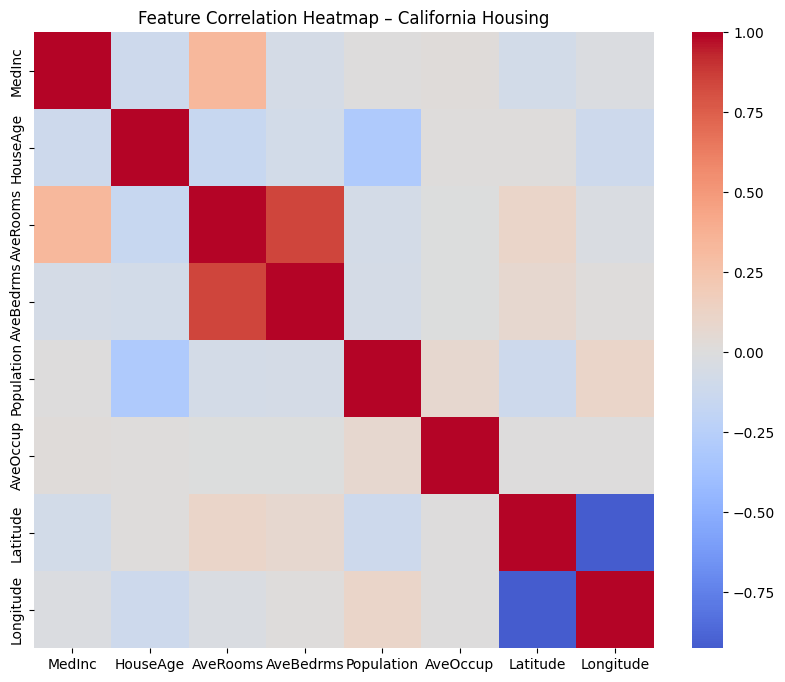

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap – California Housing")
plt.show()

### Correlation Findings

**Strong correlations**: `AveRooms` and `AveBedrms` are very closely related, and `Latitude` and `Longitude` show a strong negative correlation due to geography.  
**Moderate correlations**: `MedInc` is moderately correlated with `AveRooms`, and `Population` is moderately related to `AveOccup`.

These relationships show that multicollinearity is present in the dataset. This matters because PDP assumes features vary independently, which is not always true here. When strong correlations are present, PDP curves may exaggerate or misrepresent feature effects. ALE plots handle these dependencies better by focusing on local changes.

If this were a predictive modeling task, we would address multicollinearity by dropping or combining redundant features, or applying regularization. For this assignment, we keep all features, but correlations may influence PDP results while ALE provides a more reliable view.

*(Interpretation adapted with AI assistance, ChatGPT, 09/29/2025)*


## Partial Dependence Plots (PDP)

We first examine `MedInc` (median income), then a two-way PDP for `(MedInc, AveRooms)`.


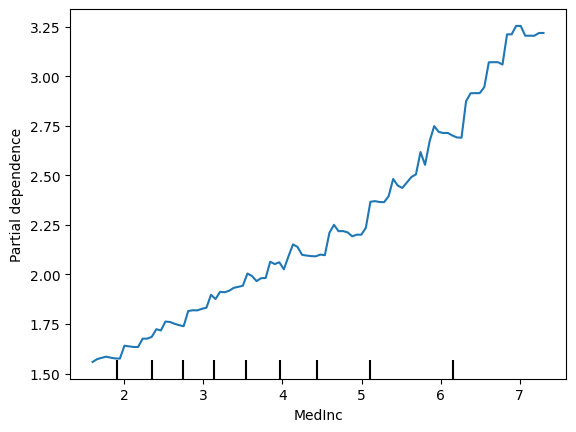

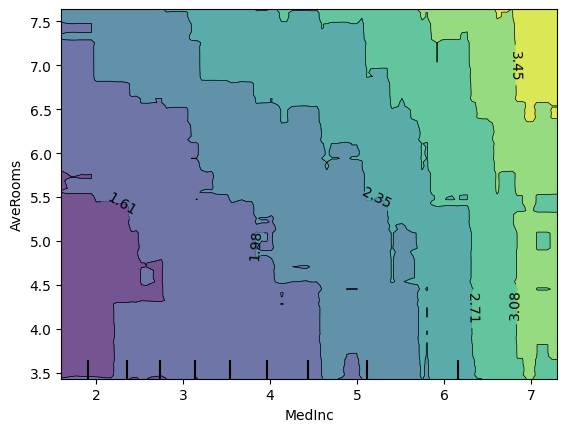

In [6]:
# PDP for a single feature
features = ["MedInc"]
PartialDependenceDisplay.from_estimator(model, X, features, kind="average")
plt.show()

# PDP for feature pair
features = [("MedInc", "AveRooms")]
PartialDependenceDisplay.from_estimator(model, X, features, kind="average")
plt.show()

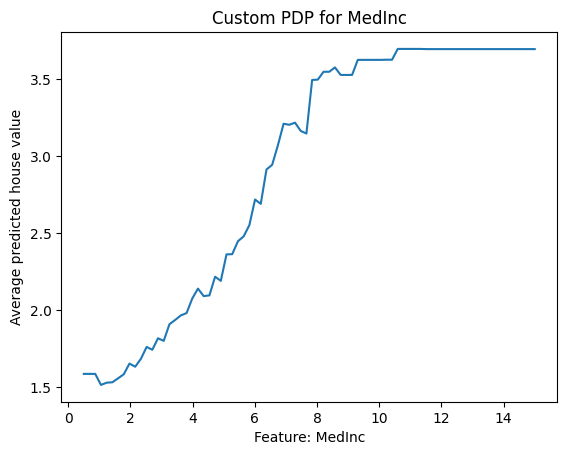

In [7]:
# Code structure adapted with AI assistance (ChatGPT, 09/29/2025)
# Choose the feature index (e.g., 0 for MedInc)
feature_index = 0  

# Create feature grid
feature_values = np.linspace(X.iloc[:, feature_index].min(), 
                             X.iloc[:, feature_index].max(), 
                             num=80)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate dataset
X_modified = X.copy()

# Loop over grid values
for i, value in enumerate(feature_values):
    # Replace chosen feature with grid value
    X_modified.iloc[:, feature_index] = value
    
    # Predict house values
    predictions = model.predict(X_modified)
    
    # Store average prediction
    average_predictions[i] = np.mean(predictions)

# Plot custom PDP
plt.plot(feature_values, average_predictions)
plt.xlabel(f"Feature: {X.columns[feature_index]}")
plt.ylabel("Average predicted house value")
plt.title(f"Custom PDP for {X.columns[feature_index]}")
plt.show()

### Interpretation

Shape of the curve: The PDPs for `MedInc` show a consistent upward slope. The relationship is generally monotonic but not perfectly linear, with steeper growth at lower to mid-income levels and a gentler increase at higher incomes.

Effect of increasing/decreasing values: As `MedInc` rises, predicted house values also rise. The model does not indicate any reversal, and higher incomes are consistently associated with higher predictions.

Plateaus or limits: At the upper end of the income scale, the curve begins to flatten. This suggests diminishing marginal effects, where additional income contributes less to predicted house values.

Domain alignment: These patterns align with housing market intuition that wealthier neighborhoods and larger homes (`MedInc` and `AveRooms` together) are priced higher, but beyond a certain point, the impact of additional income levels off rather than increasing indefinitely.

*(Interpretation adapted with AI assistance, ChatGPT, 09/29/2025)*

## Individual Conditional Expectation (ICE)

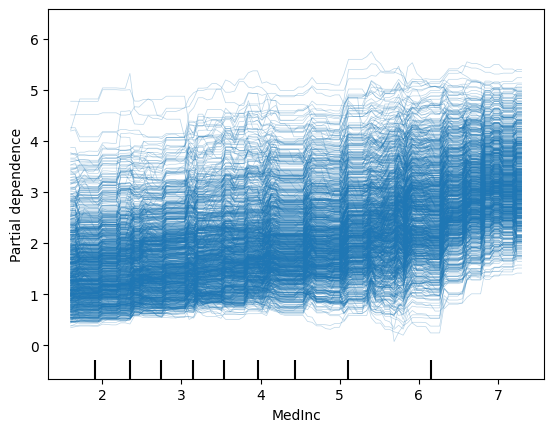

In [8]:
# ICE only (no PDP overlay) for Median Income
features = ["MedInc"]
PartialDependenceDisplay.from_estimator(model, X, features, kind="individual")
plt.show()

### Interpretation

The individual blue curves show how predicted house values change as MedInc increases. Almost all lines slope upward, but with varying steepness. This means income consistently raises predictions, though the effect is stronger in some neighborhoods than others.

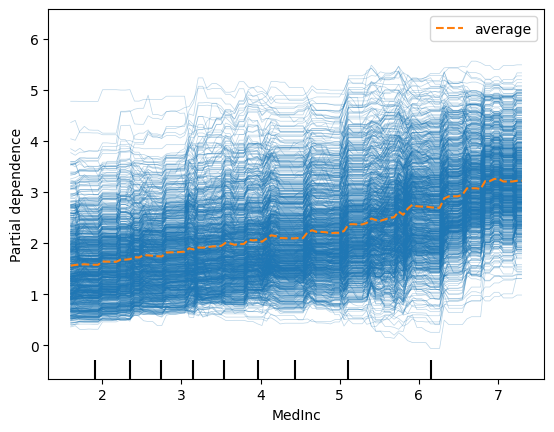

In [9]:
# ICE + PDP overlay for Median Income
features = ["MedInc"]
PartialDependenceDisplay.from_estimator(model, X, features, kind="both")
plt.show()

### Interpretation

The orange PDP line captures the average trend: higher income leads to higher predicted house values.The spread of blue ICE lines around it shows heterogeneity that not every neighborhood responds in the same way. Together, this shows both the consistent upward effect of income and the differences across individual cases.

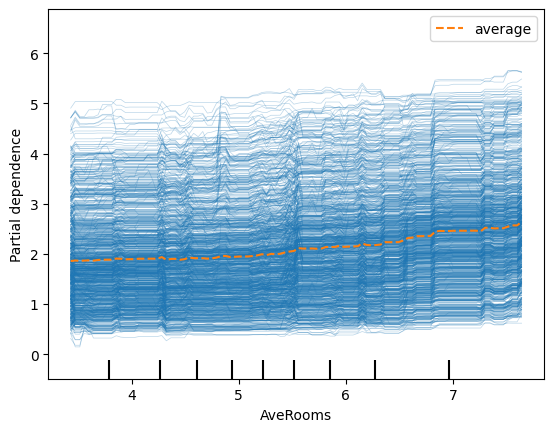

In [10]:
# ICE + PDP overlay for Average Rooms
features = ["AveRooms"]
PartialDependenceDisplay.from_estimator(model, X, features, kind="both")
plt.show()


### Interpretation

For `AveRooms`, the average PDP line also slopes upward, but less steeply than `MedInc`. Individual ICE lines vary widely, with some showing stronger positive effects than others. This means that while larger average room counts contribute to higher house values, the impact is weaker and more context-dependent compared to income.

## Accumulated Local Effects (ALE)

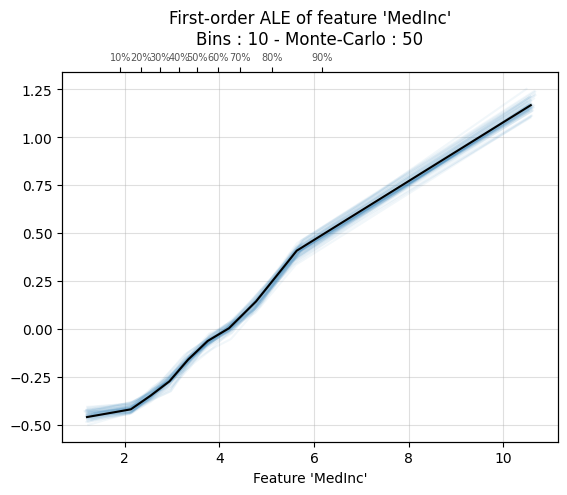

<Axes: title={'center': "First-order ALE of feature 'MedInc'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'MedInc'">

In [11]:
# 1D ALE with default parameters
ale_plot(model, X, "MedInc", monte_carlo=True)

###  Interpretation

- X-axis: median income (`MedInc`).  
- Y-axis: average effect of income on predicted house value.  
- Curve shape: the ALE curve slopes steadily upward and shows that higher income increases predicted house values. The rise is strongest from low to middle incomes, then less steep at higher values.  
- Steepness: steeper curves in the lower range mean income changes have a larger marginal impact there.  

Therefore, `MedInc` is a strong driver of house values, with a consistent positive effect across the range.  

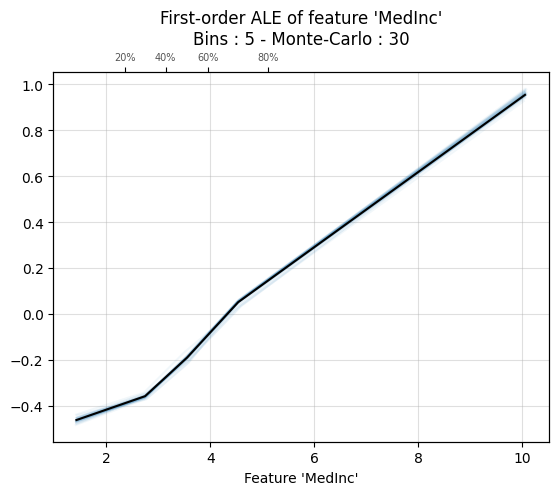

<Axes: title={'center': "First-order ALE of feature 'MedInc'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'MedInc'">

In [12]:
# Code structure adapted with AI assistance (ChatGPT, 09/29/2025)
# 1D ALE with custom bins and Monte Carlo settings
ale_plot(
    model,
    X,
    "MedInc",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5
)

### Interpretation:

- X-axis: median income values (`MedInc`).
- Y-axis: average effect on predictions.
- Curve shape: similar upward trend to the default ALE, but the line is smoother because fewer bins were used.
- Steepness: the slope is strong in the middle range, then flattens slightly at higher values.

Therefore, changing the bin/MC parameters alters smoothness but not the main insight—higher income leads to higher predicted house values. The consistency across settings shows that the ALE results are stable.

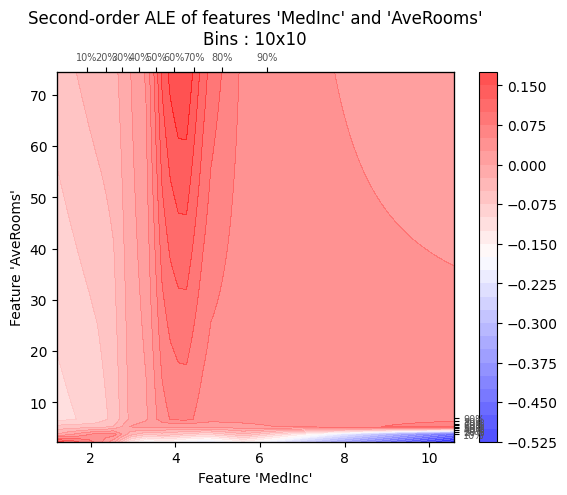

<Axes: title={'center': "Second-order ALE of features 'MedInc' and 'AveRooms'\nBins : 10x10"}, xlabel="Feature 'MedInc'", ylabel="Feature 'AveRooms'">

In [13]:
# 2D ALE for interaction between MedInc and AveRooms
ale_plot(model, X, ["MedInc", "AveRooms"], bins=10)

### Interpretation:

- X-axis: median income (`MedInc`).
- Y-axis: average rooms (`AveRooms`).
- Surface: the red regions indicate higher predicted house values, while blue areas indicate lower values.
- Patterns: predictions are highest when both `MedInc` and `AveRooms` are large, which shows a strong positive interaction. In contrast, low income with few rooms corresponds to the lowest predictions.
- Slopes: Increasing either income or rooms alone raises predictions, but their joint effect is strongest when both are high.

Therefore, the interaction between income and room size is important. Together they drive much higher predicted house values than either feature alone.

## Comparison

- **PDP**: Captures the average effect of a feature. For `MedInc`, the PDP showed a clear positive trend, but because PDP assumes features are independent, it can be biased when features are correlated (e.g., `MedInc` and `AveRooms`).  

- **ICE**: Extends PDP by showing individual variation. For `MedInc`, the ICE lines pointed that while most neighborhoods follow the upward trend, some respond more strongly than others. This shows heterogeneity that the PDP alone would hide.  

- **ALE**: Handles correlated features better by focusing on local effects. For `MedInc`, the ALE curve confirmed the upward trend but avoided bias from correlation. The 2D ALE showed how income and room count interact: both raise predicted house values, with their joint effect stronger than either feature alone.  


Therefore, all three methods point to the same conclusion that higher `MedInc` is linked with higher predicted house values, though the effect levels off at the upper end. ICE makes it clear that the strength of this effect isn’t the same everywhere. Some neighborhoods respond more strongly than others. ALE gives a more dependable view when features are correlated, as with `MedInc` and `AveRooms`, and shows how the two work together to push housing values higher. However, PDP, ICE, and ALE being used together gives a fuller picture with the average trend, the individual differences, and the correlation-adjusted effects.

